In [1]:
import stageemi
import stageemi.dev.distance_wwmf as distance_wwmf
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os 
import numpy as np
import pandas as pd
from datetime import datetime
import glob 
import time

# Parameters

In [2]:
path="../../WWMF/"
time_str='202001260000'
fname=sorted(glob.glob(path+"*"+'20200126000000'+"*"))[0]

In [3]:
# dpt
zone_dpt="38"

In [4]:
# individual zones sympo used in 3.4.3 (Find out the complementary zone sub-zones)
#indivi_zones=['4101','4102','4103','4104','4105','4106']
#indivi_zones=['3401','3402','3403','3404','3405','3406','3407','3408','3481','3482','3483']
indivi_zones=['3801','3802','3803','3804','3805','3806','3807','3808']

In [5]:
distance_choice="agat_asym"

# Opening the files

In [6]:
# compute the time
start_time = time.time()

In [7]:
# open the masks file: includes all possible masks for the departement (as proposed by Mary)
fname_mask='../../GeoData/zones_sympo_multiples/'+zone_dpt+'_mask_zones_sympos.nc'
da_mask=xr.open_dataarray(fname_mask,chunks={"id":1})

da_mask['latitude']=da_mask['latitude'].round(5)
da_mask['latitude']=da_mask['latitude'].round(5)

In [8]:
# includes as an attribute the size of each zone (in number of pixels)
zone_size_l=[len(np.where(da_mask.isel(id=i)==1)[0]) for i in np.arange(0,len(da_mask.id))]
da_mask.attrs["zone size"]=zone_size_l
#da_mask.attrs["zone size"]

In [9]:
# open the AROME dataset
ds=xr.open_dataset(fname,chunks={"step":1})
ds['latitude']=ds['latitude'].round(5)
ds['longitude']=ds['longitude'].round(5)

In [10]:
# mask the AROME dataset over the departement of interest
ds_masked=(ds*da_mask.sel(id="departement").drop("id"))

# plot one echeance step
#ds_masked.isel(step=47).unknown.plot.imshow(vmin=0,vmax=99)

# Define the output dataframe where the results are stored

In [11]:
df_zones=pd.DataFrame(columns=['zone_winning','zw_'+distance_choice,'zone_comp','zc_'+distance_choice,
                                'zone_winning_2','zw2_'+distance_choice,'zone_winning_comp','zwc_'+distance_choice,
                                'zone_comp_winning','zcw_'+distance_choice,'zone_comp_comp','zc2_'+distance_choice])

df_zones

,zone_winning,zw_agat_asym,zone_comp,zc_agat_asym,zone_winning_2,zw2_agat_asym,zone_winning_comp,zwc_agat_asym,zone_comp_winning,zcw_agat_asym,zone_comp_comp,zc2_agat_asym


# 1 Calculation of the distance for both the masks and complementary mask parts (round 1)

## 1.1 Calculation of the distance for the mask part

### 1.1.1 Calculation of the distance of the AROME map for all masks and echeance steps with respect to all wwmf_2 codes

In [12]:
ds_distance = distance_wwmf.get_pixel_distance_dept(ds_masked,distance_choice) # 4D (step:48, latitude, longitude, wwmf_2)
#ds_distance

In [13]:
# chunk per step
ds_distance_chunk = ds_distance.chunk({"step":1}) # 4D (step:48, latitude, longitude, wwmf_2)
#ds_distance_chunk

In [14]:
# return the distance for each mask id, all steps and all wwmf_2 codes
distance_by_step_id = (ds_distance_chunk * da_mask).sum(['latitude',"longitude"]).compute() # 3D (step:48, wwmf_2, id)
#distance_by_step_id

/Users/gablellouch/anaconda3/envs/preproc/lib/python3.8/site-packages/dask/array/core.py:3896: PerformanceWarning: Increasing number of chunks by factor of 48
  result = blockwise(


### 1.1.2 Calculate the minimal distance (over all wwmf_2 codes) for all echeance steps and masks

In [15]:
dist_by_step_id_min=distance_by_step_id.min("wwmf_2") # 2D (step, id)
#dist_by_step_id_min

In [16]:
# find echeance steps when the weather is the same over the entire departement (min distance is 0 for all zones)
ind_dpt=np.where(~dist_by_step_id_min.any(axis=1))[0] 
#dist_by_step_id_min

## 1.2 Calculation of the distance for the complementary mask part

### 1.2.1 Repeat the same calculation but for the complementary masks (departement-mask)

In [17]:
# first build the dataarray of complementary masks
da_mask_comp=-1*(da_mask.isel(id=slice(0,len(da_mask.id)))-da_mask.isel(id=0))

In [18]:
# includes as an attribute the size of each zone (in number of pixels)
zone_comp_size_l=[len(np.where(da_mask_comp.isel(id=i)==1)[0]) for i in np.arange(0,len(da_mask.id))]
da_mask_comp.attrs["zone size"]=zone_comp_size_l
#da_mask_comp

In [19]:
# return the distance for each 'complementary mask id', all steps and all wwmf_2 codes
distance_comp_by_step_id = (ds_distance_chunk * da_mask_comp).sum(['latitude',"longitude"]).compute() # 3D (step:48, wwmf_2, id)
#distance_comp_by_step_id

/Users/gablellouch/anaconda3/envs/preproc/lib/python3.8/site-packages/dask/array/core.py:3896: PerformanceWarning: Increasing number of chunks by factor of 48
  result = blockwise(


### 1.2.2 Calculate the minimal distance (over all wwmf_2 codes) for all echeance steps and complementary masks

In [20]:
dist_comp_by_step_id_min=distance_comp_by_step_id.min("wwmf_2") # 2D (step, id)
# dist_comp_by_step_id_min[:,1:] (the first column is the empty mask: departement-departement)

## 1.3 Find the mask (zone) that minimizes the sum of the distances (mask and complementary part = entire departement): the 'winning zone'

In [21]:
# sum both distance min arrays
dist_sum_by_step_id_min=dist_by_step_id_min[:,1:]+dist_comp_by_step_id_min[:,1:] # we do not account for the trivial case of the departement since we aim at zoning it

In [22]:
# first, the indices of the winning zones in terms of the criterion: minimization of the sum of the distances
ind_winning_zone=dist_sum_by_step_id_min.argmin(("id")).values+1 # +1 because the array "dist_sum_by_step_id_min" has been reduced by the first column (departement) 
#ind_winning_zone # type is: ndarray

# going back to the "temps sensible" info for the winning zone
tps_sensible_winning_zone=distance_by_step_id.wwmf_2[distance_by_step_id.argmin("wwmf_2").values[np.arange(0,ds_masked.dims['step']),ind_winning_zone]]

# and for the complementary of the winning zone
tps_sensible_winning_zone_comp=distance_comp_by_step_id.wwmf_2[distance_comp_by_step_id.argmin("wwmf_2").values[np.arange(0,ds_masked.dims['step']),ind_winning_zone]]

# id of the winning zones
zoneswinning=dist_sum_by_step_id_min.id[dist_sum_by_step_id_min.argmin(("id"))].values # note that dist_sum_by_step_id_min.id does not include id: departement

In [23]:
# temps sensible to store
tps_sensible_winning_zone
#tps_sensible_winning_zone_comp

<xarray.DataArray 'wwmf_2' (wwmf_2: 48)>
array([ 0, 21, 13, 13, 13, 13,  7,  7,  7,  0,  0,  7, 13, 13,  0,  0, 13,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  7,  0,  7,  7, 13, 13,  0])
Coordinates:
    surface            int64 0
    heightAboveGround  int64 2
  * wwmf_2             (wwmf_2) int64 0 21 13 13 13 13 7 7 ... 0 7 0 7 7 13 13 0
    time               datetime64[ns] 2019-10-01
    valid_time         datetime64[ns] 2019-10-01T12:00:00

In [24]:
# for echeances when the same weather applies over the entire departement we indicate "departement" for the "zone_winning"
zoneswinning[ind_dpt]="departement"

In [25]:
df_zones["zone_winning"]=zoneswinning
df_zones["zw_"+distance_choice]=tps_sensible_winning_zone
df_zones["zc_"+distance_choice]=tps_sensible_winning_zone_comp
df_zones

,zone_winning,zw_agat_asym,zone_comp,zc_agat_asym,zone_winning_2,zw2_agat_asym,zone_winning_comp,zwc_agat_asym,zone_comp_winning,zcw_agat_asym,zone_comp_comp,zc2_agat_asym
0,3801+3802+3803+3806+3807+3808,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3803,21,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3801+3803+3806,13,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3801+3802+3803+3804+3805+3806+3808,13,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3801+3802+3803+3805+3806+3808,13,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,3801+3802+3803+3806,13,NaN,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,3803+3804+3807+3808,7,NaN,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,3803+3804+3805+3806+3807+3808,7,NaN,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,3803+3804+3805+3806+3807+3808,7,NaN,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,3803+3804+3808,0,NaN,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 2. Find those zones that present a high value of mean distance per pixel greater than the median value of mean distance per pixel over the departement and all echeance steps

## 2.1 Calculation of the median of the mean distance per pixel over the departement and all echeance steps

### 2.1.1 Zones for which the sum of the distances (zone + complementary zone) is minimum per echeance step

In [26]:
# calculation of the minimum distance per echeance step
dist_min_sum_by_step=dist_sum_by_step_id_min[:,dist_sum_by_step_id_min.argmin(("id"))]

In [27]:
# recall the winning zone indices 
#ind_winning_zone

In [28]:
# define the winning zones indices in dataarray (it is important for the next two steps so that a vector is created, not a square matrix if one uses a ndarray)
zone_sum_with_dist_min_by_step=dist_sum_by_step_id_min.argmin(("id"))+1 # +1 is to compensate for the first column (complementary of the departement that we dropped)
#zone_sum_with_dist_min_by_step

### 2.1.2 Mean value of the distance per pixel for all winning zones and their complementary zones (the mean distance per pixel = distance density here)

In [29]:
# find distance values for the winning zones 
dist_min_by_step_fordensity=dist_by_step_id_min[:,zone_sum_with_dist_min_by_step]
#dist_min_by_step_fordensity.values

In [30]:
# find distance values for the complementary zones 
dist_comp_min_by_step_fordensity=dist_comp_by_step_id_min[:,zone_sum_with_dist_min_by_step]
#dist_comp_min_by_step_fordensity.values

In [31]:
# check that when we sum them up we retrieve the values we found earlier in 2.1.1
dist_min_by_step_fordensity.values+dist_comp_min_by_step_fordensity.values

# should be equal to 
#dist_min_sum_by_step.values

array([ 3208.91,  5057.42,  9260.4 ,  9399.4 ,  8728.26,  7447.07,
        8004.74,  7448.82,  9451.77, 11252.26, 10004.33,  8885.72,
       10341.99,  8446.38,  8437.61,  7703.8 ,  7504.51,  5414.34,
        6281.01,  5678.41,  3797.27,  4086.78,  3764.54,  2670.95,
        2494.16,  2939.83,  3872.63,  5283.44,  6520.45,  5746.05,
        4163.03,  3121.13,  2231.12,   888.11,   242.37,   138.23,
         256.79,   241.69,  1037.05,  1633.42,  2903.24,  4252.92,
        4438.66,  9635.67, 10626.09, 13160.92,  8502.55,  6853.68])

In [32]:
# find the zone size for all winning zones for further averaging (per pixel)
zone_size_distmin=[zone_size_l[zone_sum_with_dist_min_by_step.values[i]] for i in np.arange(0,48)]

In [33]:
# compute the median "mean distance per pixel value" (or density) over all winning zones
density_dist_min_by_step=dist_min_by_step_fordensity.values/zone_size_distmin
density_dist_min_by_step_median=np.median(density_dist_min_by_step)
density_dist_min_by_step_median

0.4646043475262953

In [34]:
# idem (zone size) for the complementary zones
zone_comp_size_distmin=[zone_comp_size_l[zone_sum_with_dist_min_by_step.values[i]] for i in np.arange(0,48)]

In [35]:
# idem (median "mean distance per pixel value" (or density)) over all complementary zones
density_dist_comp_min_by_step=dist_comp_min_by_step_fordensity.values/zone_comp_size_distmin
density_dist_comp_min_by_step_median=np.median(density_dist_comp_min_by_step)
density_dist_comp_min_by_step_median

0.4657397815833897

## 2.2 Find echeances steps that have winning zones that fulfill this condition (mean distance per pixel greater than the median value) plus are composed of two zones or more

### 2.2.1 Winning zones

In [36]:
# find the echeance steps with heterogeneous winning zones
step_zones_hetero=np.where(density_dist_min_by_step>density_dist_min_by_step_median)[0]
step_zones_hetero

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 15, 16, 18, 19,
       29, 41, 43, 44, 45, 46, 47])

In [37]:
# find the zones with multiple zones sympo in it 
id_zones_multiple=np.where(['+' in val for val in da_mask.id.values.tolist()])[0]
#id_zones_multiple

In [38]:
# remember the winning zones per echeance (for info)
#zone_sum_with_dist_min_by_step
# remember the winning zones per echeance that are heterogenous (for info)
#zone_sum_with_dist_min_by_step[step_zones_hetero]
len(step_zones_hetero)

24

In [39]:
# mark those echeances that have both heterogeneous winning zones and are composed of multiple zone sympo
step_zones_hetero_and_multiple=step_zones_hetero[np.where([zone_sum_with_dist_min_by_step.values[step_zones_hetero][i] in id_zones_multiple for i in np.arange(0,len(step_zones_hetero))])[0]]
#step_zones_hetero_and_multiple

In [40]:
# and the zones are the following:
zones=[da_mask.id.values.tolist()[zone_sum_with_dist_min_by_step.values[i]] for i in step_zones_hetero_and_multiple]
#zones

### 2.2.2 Complementary zones

In [41]:
# find the echeance steps with heterogeneous complementary winning zones
step_zones_comp_hetero=np.where(density_dist_comp_min_by_step>density_dist_comp_min_by_step_median)[0]
#step_zones_comp_hetero

In [42]:
# nb of zones sympo in the department (to know the indices of the complementary zones with multiple zones sympo)
zs_N=len([zs for zs in da_mask.id.values.tolist() if "+" not in zs])-1 # -1 to remove the departement from the counting

In [43]:
# find the complementary zones with multiple zones sympo in it 
id_zones_comp_multiple=np.where([val.count('+')<(zs_N-2) for val in da_mask.id.values.tolist()])[0][1:] # we ignore the department since the complementary zone is the empty space
#id_zones_comp_multiple

In [44]:
# remember the winning zones per echeance
#zone_sum_with_dist_min_by_step.values
# remember the winning zones per echeance that are heterogenous 
#zone_sum_with_dist_min_by_step.values[step_zones_comp_hetero]

In [45]:
# mark those echeances that have both heterogeneous winning complementary zones and are composed of multiple zone sympo
step_zones_comp_hetero_and_multiple=step_zones_comp_hetero[np.where([zone_sum_with_dist_min_by_step.values[step_zones_comp_hetero][i] in id_zones_comp_multiple for i in np.arange(0,len(step_zones_hetero))])[0]]
#step_zones_comp_hetero_and_multiple

In [46]:
# and the complementary zones are the following (in fact they are the complementary of these zones):
zones_comp=[da_mask.id.values.tolist()[zone_sum_with_dist_min_by_step.values[i]] for i in step_zones_comp_hetero_and_multiple]
#zones_comp

## 2.3 Generate the new dataset for the winning heterogeneous zones + complementary zones (with multiple zone sympo). Zones that did not pass the criteria are fully masked.


In [47]:
# (Check) adding the zone and its complementary one gets the department size
#np.asarray(da_mask.attrs["zone size"])+np.asarray(da_mask_comp.attrs["zone size"])

### 2.3.1 Create the winning zone dataset

In [48]:
# create the dataaset where masks corresponding to zones that shall be redivided (zones) are applied on the appropriate echeance step (step_zones_hetero_and_multiple)
tmp_masks=np.full([ds_masked.dims['step'], ds_masked.dims['latitude'], ds_masked.dims['longitude']], np.nan)

In [49]:
for i in np.arange(0,ds.dims['step']):  
    if i in step_zones_hetero_and_multiple: 
        ind_tmp=zone_sum_with_dist_min_by_step.values[i]
        mask_tmp=da_mask.isel(id=ind_tmp)
        mask_tmp=mask_tmp.where(mask_tmp!=0,np.nan)        
        tmp_masks[i,:,:]=(ds.isel(step=i).unknown*mask_tmp).values 

In [50]:
# build the new ds
ds_masked_zones_hetero=xr.Dataset(coords={'step':ds_masked['step'],'latitude':ds_masked['latitude'],'longitude':ds_masked['longitude']})
ds_masked_zones_hetero["unknown"]=(tuple(['step','latitude','longitude']),tmp_masks)
#ds_masked_zones_hetero

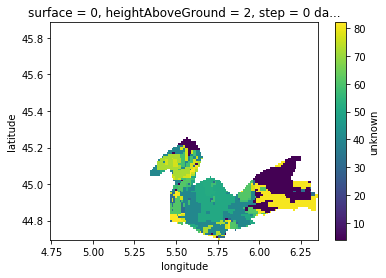

In [51]:
# check on one case (look at one step that is applicable)
ds_masked_zones_hetero.isel(step=2).unknown.plot.imshow();

### 2.3.2 Create the complementary zone dataset

In [52]:
# create the dataset where masks corresponding to complementary zones that shall be redivided (zones_comp) are applied on the appropriate echeance step (step_zones_comp_hetero_and_multiple)
tmp_masks_comp=np.full([ds_masked.dims['step'], ds_masked.dims['latitude'], ds_masked.dims['longitude']], np.nan)

In [53]:
for i in np.arange(0,ds.dims['step']):  
    if i in step_zones_comp_hetero_and_multiple: 
        ind_comp_tmp=zone_sum_with_dist_min_by_step.values[i]
        
        mask_comp_tmp=da_mask_comp.isel(id=ind_comp_tmp)
        mask_comp_tmp=mask_comp_tmp.where(mask_comp_tmp!=0,np.nan) 
        
        tmp_masks_comp[i,:,:]=(ds.isel(step=i).unknown*mask_comp_tmp).values 

In [54]:
# build the new dataset 
ds_masked_zones_comp_hetero=xr.Dataset(coords={'step':ds_masked['step'],'latitude':ds_masked['latitude'],'longitude':ds_masked['longitude']})
ds_masked_zones_comp_hetero["unknown"]=(tuple(['step','latitude','longitude']),tmp_masks_comp)
#ds_masked_zones_comp_hetero

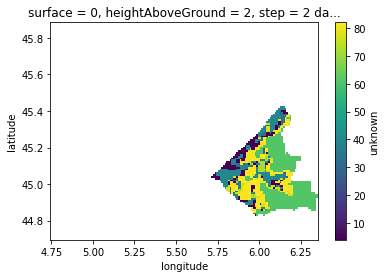

In [55]:
# check on one case (again one step that is applicable)
ds_masked_zones_comp_hetero.isel(step=47).unknown.plot.imshow();

# 3 Apply the distance calculation on these two new datasets composed of the heterogeneous winning zones and complementary zones (round 2)

## 3.1 Winning zones

### 3.1.1 Zones for the winning zones

In [56]:
# calculation of the distance for the new dataset (winning zones)
ds_distance_round2zones = distance_wwmf.get_pixel_distance_dept(ds_masked_zones_hetero,distance_choice) # 4D (step:48, latitude, longitude, wwmf_2)

In [57]:
ds_distance_round2zones_chunk = ds_distance_round2zones.chunk({"step":1}) # 4D (step:48, latitude, longitude, wwmf_2)
#ds_distance_round2zones_chunk

### 3.1.2 Define a new dataarray of masks: idea here is to change 0 into nan (though it may not be any different than with da_mask)

In [58]:
tmp_mask_round2=np.full([da_mask.shape[0], da_mask.shape[1], da_mask.shape[2]], np.nan)

In [59]:
# initialization
da_mask_round2=da_mask

for i in np.arange(0,da_mask.shape[0]):   
    mask_tmp_round2=da_mask.isel(id=i)
    mask_tmp_round2=mask_tmp_round2.where(mask_tmp_round2!=0,np.nan)  
    tmp_mask_round2[i,:,:]=mask_tmp_round2

In [60]:
da_mask_round2=xr.DataArray(data=tmp_mask_round2,coords={'id':da_mask.id.values,'latitude':da_mask.latitude.values,'longitude':da_mask.longitude.values},dims={'id':da_mask.shape[0],'latitude':da_mask.shape[1],'longitude':da_mask.shape[2]})
#da_mask_round2

### 3.1.3 Distance calculation

In [61]:
distance_round2zones_by_step_id = (ds_distance_round2zones_chunk * da_mask_round2).sum(['latitude',"longitude"]).compute() # 3D (step:48, wwmf_2, id)


In [62]:
# one can compare both masks and see that zeros were replaced by nan
#da_mask.isel(id=20).plot.imshow()
#da_mask_round2.isel(id=20).plot.imshow()

In [63]:
# list of the zones hetero and multiple (recall from earlier)
zoneswinning=dist_sum_by_step_id_min.id[dist_sum_by_step_id_min.argmin(("id"))].values 
#zoneswinning

In [64]:
# find the id of the subset of zones included in the winning zone for each echeance step when round 2 is applicable
id_zone_included=[np.nan]*ds_masked.dims['step']

for i in step_zones_hetero_and_multiple:
    id_zone_included[i]=np.where([set(val.split("+")).issubset(zoneswinning[i].split("+")) for val in da_mask.id.values.tolist()])[0]

In [65]:
# verify that this works well by comparing one zone and the corresponding subzones 
#zoneswinning[47]
#[da_mask.id.values.tolist()[i] for i in id_zone_included[47]]

## 3.2 Complementary of the winning zones

### 3.2.1 Define a new dataarray of complementary masks

In [66]:
tmp_mask_comp_round2=np.full([da_mask.shape[0], da_mask.shape[1], da_mask.shape[2]], np.nan)

In [67]:
# initialization
da_mask_comp_round2=da_mask_comp

for i in np.arange(0,da_mask.shape[0]):   
    mask_comp_tmp_round2=da_mask_comp.isel(id=i)
    mask_comp_tmp_round2=mask_comp_tmp_round2.where(mask_comp_tmp_round2!=0,np.nan)  
    tmp_mask_comp_round2[i,:,:]=mask_comp_tmp_round2

In [68]:
da_mask_comp_round2=xr.DataArray(data=tmp_mask_comp_round2,coords={'id':da_mask.id.values,'latitude':da_mask.latitude.values,'longitude':da_mask.longitude.values},dims={'id':da_mask.shape[0],'latitude':da_mask.shape[1],'longitude':da_mask.shape[2]})
#da_mask_comp_round2

In [69]:
# again one can compare both masks and see that zeros were replaced by nan
#da_mask_comp.isel(id=20).plot.imshow()
#da_mask_comp_round2.isel(id=20).plot.imshow()

### 3.2.2 Distance calculation

In [70]:
distance_round2zones_comp_by_step_id = (ds_distance_round2zones_chunk * da_mask_comp_round2).sum(['latitude',"longitude"]).compute()

## 3.3 Find the new winning zones and their complementary zones

### 3.3.1 Minimization of the sum of the distances

In [71]:
# calculate the minimal distance (over all wwmf_2 codes) for all echeance steps and masks
distance_round2zones_by_step_id_min=distance_round2zones_by_step_id.min("wwmf_2") # 2D (step, id)

# idem for the complementary zones
distance_round2zones_comp_by_step_id_min=distance_round2zones_comp_by_step_id.min("wwmf_2") # 2D (step, id)

# summing both distances
dist_round2zones_sum_by_step_id_min=distance_round2zones_by_step_id_min+distance_round2zones_comp_by_step_id_min

### 3.3.2 New zones and complementary zones and the corresponding temps sensible: analysis

In [72]:
# initialize
ind_zone_distmin_round2_by_step=np.full([ds_masked_zones_hetero.dims["step"]], np.nan) 
dist_round2_sum_by_step_min=np.full([ds_masked_zones_hetero.dims["step"]], np.nan) 
tps_sens_round2=np.full([ds_masked_zones_hetero.dims["step"]], np.nan)
tps_sens_comp_round2=np.full([ds_masked_zones_hetero.dims["step"]], np.nan)

# new winning zone id
name_zone_round2=['nan']*ds_masked_zones_hetero.dims["step"]
# new complementary winning zone id
name_zone_round2_comp=['nan']*ds_masked_zones_hetero.dims["step"]

In [73]:
# recall 
#step_zones_hetero_and_multiple

In [74]:
# recall
#zoneswinning

In [75]:
for i in step_zones_hetero_and_multiple:

    # the min distance is the same for all sub zones (initial winning zone included), hence we state that no further division shall be applied (this case often happened for dpt 41, 26/01/2010 with COMPAS)
    # instead of the equality (okay for compas but not agat) we use an inequality with eps=0.00001 to find if all subzones give the same output
    if len(np.where(dist_round2zones_sum_by_step_id_min.isel(step=i)[id_zone_included[i]]-min(dist_round2zones_sum_by_step_id_min.isel(step=i)[id_zone_included[i]])<0.00001)[0])==len(id_zone_included[i]):
        print('Echeance '+str(i)+': no further zoning within the initial winning zone '+zoneswinning[i])
        # need to transform indices into wwmf_2 code (same applies to all tps_sens)
        tps_sens_round2[i]=distance_round2zones_by_step_id.wwmf_2[distance_round2zones_by_step_id.isel(step=i).argmin("wwmf_2")[id_zone_included[i]].max()].values
        tps_sens_comp_round2[i]=distance_round2zones_comp_by_step_id.wwmf_2[distance_round2zones_comp_by_step_id.isel(step=i).argmin("wwmf_2")[id_zone_included[i]].max()].values
        print('Temps sensible in any new zone: '+str(int(tps_sens_round2[i])))
        print('Temps sensible in any new complementary zone: '+str(int(tps_sens_comp_round2[i])),'(Both shall be the same!)','\n')
        
        df_zones["zone_winning_2"].iloc[i]=zoneswinning[i]
        df_zones["zw2_"+distance_choice].iloc[i]=int(tps_sens_round2[i])
        df_zones["zwc_"+distance_choice].iloc[i]=int(tps_sens_comp_round2[i])        
        
    # we divide further
    else: 
        ind_zone_distmin_round2_by_step[i]=dist_round2zones_sum_by_step_id_min.isel(step=i)[id_zone_included[i]].argmin().values
        dist_round2_sum_by_step_min[i]=dist_round2zones_sum_by_step_id_min.isel(step=i)[id_zone_included[i]].min().values
               
        # the min distance is obtained for the initial winning zone, hence we shall not divide further
        if str(dist_round2zones_sum_by_step_id_min.isel(step=i).id[id_zone_included[i]][int(ind_zone_distmin_round2_by_step[i])].values)==zoneswinning[i]:
        
            # we still fill in with information (to remain consistant with the above: we fill in info for all echeances that went to round2 except temps sensible for the complementary zone since this zone is empty)           
            tps_sens_round2[i]=int(distance_round2zones_by_step_id.wwmf_2[distance_round2zones_by_step_id.isel(step=i).argmin("wwmf_2")[id_zone_included[i]][int(ind_zone_distmin_round2_by_step[i])]].values)

            print('Echeance '+str(i)+': the winning zone 2 is still the same: '+zoneswinning[i])
            print('Temps sensible is: '+str(int(tps_sens_round2[i])),'. Check that it is still the same as found in round 1 \n')

            df_zones["zone_winning_2"].iloc[i]=zoneswinning[i]
            df_zones["zw2_"+distance_choice].iloc[i]=int(tps_sens_round2[i])
            
        # we really divide further
        else:
        
            tps_sens_round2[i]=int(distance_round2zones_by_step_id.wwmf_2[distance_round2zones_by_step_id.isel(step=i).argmin("wwmf_2")[id_zone_included[i]][int(ind_zone_distmin_round2_by_step[i])]].values)
            tps_sens_comp_round2[i]=int(distance_round2zones_by_step_id.wwmf_2[distance_round2zones_comp_by_step_id.isel(step=i).argmin("wwmf_2")[id_zone_included[i]][int(ind_zone_distmin_round2_by_step[i])]].values)

            name_zone_round2[i]=str(dist_round2zones_sum_by_step_id_min.isel(step=i).id[id_zone_included[i]][int(ind_zone_distmin_round2_by_step[i])].values)

            print('\nEcheance ',str(i),': YES! Further zoning applies within the initial winning zone ',zoneswinning[i],',viz.:',name_zone_round2[i])
            print('Temps sensible is: '+str(int(tps_sens_round2[i])),'in the new winning zone')
            print('Temps sensible is: '+str(int(tps_sens_comp_round2[i])),'in the new complementary zone','\n')

            df_zones["zone_winning_2"].iloc[i]=name_zone_round2[i]
            df_zones["zw2_"+distance_choice].iloc[i]=int(tps_sens_round2[i])
            df_zones["zwc_"+distance_choice].iloc[i]=int(tps_sens_comp_round2[i])

            # find the zone winning complementary:
            # elements of the complementary zone
            zone_tmp=np.setdiff1d(zoneswinning[i].split('+'),name_zone_round2[i].split('+')).tolist()

            # corresponding zone id (there shall be one and only one in the list)
            if len(np.where([da_mask.id[i].values.tolist().split('+')==zone_tmp for i in np.arange(0,len(da_mask.id))])[0])>0:
                ind_zone_tmp=np.where([da_mask.id[i].values.tolist().split('+')==zone_tmp for i in np.arange(0,len(da_mask.id))])[0][0]
                name_zone_round2_comp[i]=str(da_mask.id[ind_zone_tmp].values.tolist())
                df_zones["zone_winning_comp"].iloc[i]=name_zone_round2_comp[i]
            else:
                df_zones["zone_winning_comp"].iloc[i]=str('+'.join(zone_tmp))
                print('warning: the complementary zone does not seem to be any of the original zones: ',df_zones["zone_winning_comp"].iloc[i],'\n')


            

Echeance 2: the winning zone 2 is still the same: 3801+3803+3806
Temps sensible is: 13 . Check that it is still the same as found in round 1 

Echeance 3: the winning zone 2 is still the same: 3801+3802+3803+3804+3805+3806+3808
Temps sensible is: 13 . Check that it is still the same as found in round 1 

Echeance 4: the winning zone 2 is still the same: 3801+3802+3803+3805+3806+3808
Temps sensible is: 13 . Check that it is still the same as found in round 1 

Echeance 5: the winning zone 2 is still the same: 3801+3802+3803+3806
Temps sensible is: 13 . Check that it is still the same as found in round 1 

Echeance 6: the winning zone 2 is still the same: 3803+3804+3807+3808
Temps sensible is: 7 . Check that it is still the same as found in round 1 

Echeance 7: the winning zone 2 is still the same: 3803+3804+3805+3806+3807+3808
Temps sensible is: 7 . Check that it is still the same as found in round 1 



/Users/gablellouch/anaconda3/envs/preproc/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/gablellouch/anaconda3/envs/preproc/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/gablellouch/anaconda3/envs/preproc/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata


Echeance  8 : YES! Further zoning applies within the initial winning zone  3803+3804+3805+3806+3807+3808 ,viz.: 3804+3805+3807+3806+3808
Temps sensible is: 7 in the new winning zone
Temps sensible is: 0 in the new complementary zone 

Echeance 9: no further zoning within the initial winning zone 3803+3804+3808
Temps sensible in any new zone: 0
Temps sensible in any new complementary zone: 0 (Both shall be the same!) 

Echeance 10: no further zoning within the initial winning zone 3804+3807+3808
Temps sensible in any new zone: 0
Temps sensible in any new complementary zone: 0 (Both shall be the same!) 

Echeance 11: the winning zone 2 is still the same: 3801+3803+3806+3808
Temps sensible is: 7 . Check that it is still the same as found in round 1 



/Users/gablellouch/anaconda3/envs/preproc/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/gablellouch/anaconda3/envs/preproc/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/gablellouch/anaconda3/envs/preproc/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata

Echeance 12: the winning zone 2 is still the same: 3801+3802+3803+3804+3805+3806+3808
Temps sensible is: 13 . Check that it is still the same as found in round 1 

Echeance 13: the winning zone 2 is still the same: 3801+3802+3804+3805+3804+3806
Temps sensible is: 13 . Check that it is still the same as found in round 1 

Echeance 15: no further zoning within the initial winning zone 3803+3804+3805+3806+3807+3808
Temps sensible in any new zone: 0
Temps sensible in any new complementary zone: 0 (Both shall be the same!) 

Echeance 18: no further zoning within the initial winning zone 3802+3803+3804+3805+3807+3806+3808
Temps sensible in any new zone: 0
Temps sensible in any new complementary zone: 0 (Both shall be the same!) 

Echeance 19: no further zoning within the initial winning zone 3802+3804+3807
Temps sensible in any new zone: 0
Temps sensible in any new complementary zone: 0 (Both shall be the same!) 

Echeance 44: the winning zone 2 is still the same: 3803+3804+3806+3807+3808
Te

/Users/gablellouch/anaconda3/envs/preproc/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/gablellouch/anaconda3/envs/preproc/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/gablellouch/anaconda3/envs/preproc/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata

## 3.4 Complementary of the winning zones

### 3.4.1 Zones for the complementary of the winning zones

In [76]:
ds_distance_round2compzones= distance_wwmf.get_pixel_distance_dept(ds_masked_zones_comp_hetero,distance_choice) # 4D (step:48, latitude, longitude, wwmf_2)
ds_distance_round2compzones_chunk = ds_distance_round2compzones.chunk({"step":1}) # 4D (step:48, latitude, longitude, wwmf_2)
distance_round2compzones_by_step_id = (ds_distance_round2compzones_chunk * da_mask_round2).sum(['latitude',"longitude"]).compute() # 3D (step:48, wwmf_2, id)

### 3.4.2 Complementary zones for the complementary of the winning zones


In [77]:
distance_round2compzones_comp_by_step_id = (ds_distance_round2compzones_chunk * da_mask_comp_round2).sum(['latitude',"longitude"]).compute()

### 3.4.3 Find out the complementary zone sub-zones

In [78]:
# we create the list of the complementary winning zones
# indivi_zones was defined in the very beginning (parameters)
zoneswinning_comp=['']*len(zoneswinning)

for ii,i in enumerate(zoneswinning):
    tmp=[]
    for j in indivi_zones:
        if j not in i.split("+"):            
            tmp.append(j)
    zoneswinning_comp[ii]='+'.join(tmp)
zoneswinning_comp=np.asarray(zoneswinning_comp)

In [79]:
df_zones["zone_comp"]=zoneswinning_comp

In [80]:
#zoneswinning_comp[step_zones_comp_hetero_and_multiple]

In [81]:
# recall the echeance steps to consider
#step_zones_comp_hetero_and_multiple

In [82]:
# find the id of the subset of zones included in the COMPLEMENTARY winning zone for each echeance step when round 2 is applicable
id_compzone_included=[np.nan]*ds_masked.dims['step']

for i in step_zones_comp_hetero_and_multiple:
    id_compzone_included[i]=np.where([set(val.split("+")).issubset(zoneswinning_comp[i].split("+")) for val in da_mask.id.values.tolist()])[0]

In [83]:
# verify that this works well by comparing one zone and the corresponding subzones
#zoneswinning_comp[47]
#[da_mask.id.values.tolist()[i] for i in id_compzone_included[47]]

### 3.4.4 Minimization of the sum of the distances

In [84]:
distance_round2compzones_by_step_id_min=distance_round2compzones_by_step_id.min("wwmf_2")
distance_round2compzones_comp_by_step_id_min=distance_round2compzones_comp_by_step_id.min("wwmf_2")
dist_round2compzones_sum_by_step_id_min=distance_round2compzones_by_step_id_min+distance_round2compzones_comp_by_step_id_min

### 3.4.5 New zones and complementary zones and the corresponding temps sensible: analysis

In [85]:
# initialize
ind_compzone_distmin_round2_by_step=np.full([ds_masked_zones_comp_hetero.dims["step"]], np.nan)  
dist_comp_round2_sum_by_step_min=np.full([ds_masked_zones_comp_hetero.dims["step"]], np.nan) 
tps_sens_comp_round2=np.full([ds_masked_zones_comp_hetero.dims["step"]], np.nan)
tps_sens_comp_of_comp_round2=np.full([ds_masked_zones_hetero.dims["step"]], np.nan)

# new winning zone id
name_compzone_round2=['nan']*ds_masked_zones_hetero.dims["step"]

# new complementary winning zone id
name_compzone_round2_comp=['nan']*ds_masked_zones_hetero.dims["step"]

In [86]:
for i in step_zones_comp_hetero_and_multiple:

    # same as in the previous winning zone case
    if len(np.where(dist_round2compzones_sum_by_step_id_min.isel(step=i)[id_compzone_included[i]]-min(dist_round2compzones_sum_by_step_id_min.isel(step=i)[id_compzone_included[i]])<0.00001)[0])==len(id_compzone_included[i]):
        print('Echeance '+str(i)+': no further zoning within the initial complementary winning zone '+zoneswinning_comp[i])
        # here again, need to transform indices into wwmf_2 code (same applies to all tps_sens)
        tps_sens_comp_round2[i]=int(distance_round2compzones_by_step_id.wwmf_2[distance_round2compzones_by_step_id.isel(step=i).argmin("wwmf_2")[id_compzone_included[i]].max()].values)
        tps_sens_comp_of_comp_round2[i]=int(distance_round2compzones_comp_by_step_id.wwmf_2[distance_round2compzones_comp_by_step_id.isel(step=i).argmin("wwmf_2")[id_compzone_included[i]].max()].values)
        print('Temps sensible in any new zone (of the complementary): '+str(int(tps_sens_comp_round2[i])))
        print('Temps sensible in any new complementary zone (of the complementary): '+str(int(tps_sens_comp_of_comp_round2[i])),'(Both shall be the same!)','\n')
        
        df_zones["zone_comp_winning"].iloc[i]=zoneswinning_comp[i]
        df_zones["zcw_"+distance_choice].iloc[i]=int(tps_sens_comp_round2[i])
        df_zones["zc2_"+distance_choice].iloc[i]=int(tps_sens_comp_of_comp_round2[i])
        
    else:        
        ind_compzone_distmin_round2_by_step[i]=dist_round2compzones_sum_by_step_id_min.isel(step=i)[id_compzone_included[i]].argmin().values
        dist_comp_round2_sum_by_step_min[i]=dist_round2compzones_sum_by_step_id_min.isel(step=i)[id_compzone_included[i]].min().values
        
        # the min distance is obtained for the initial complementary zone, hence we shall not divide further
        if str(dist_round2compzones_sum_by_step_id_min.isel(step=i).id[id_compzone_included[i]][int(ind_compzone_distmin_round2_by_step[i])].values)==zoneswinning_comp[i]:
        
            # we still fill in with information (to remain consistant with the above: we fill in info for all echeances that went to round2 except temps sensible for the complementary zone since this zone is empty)
            
            tps_sens_comp_round2[i]=int(distance_round2compzones_by_step_id.wwmf_2[distance_round2compzones_by_step_id.isel(step=i).argmin("wwmf_2")[id_compzone_included[i]][int(ind_compzone_distmin_round2_by_step[i])]].values)

            print('Echeance '+str(i)+': the complementary winning zone is still the same: '+zoneswinning_comp[i])
            print('Temps sensible is: '+str(int(tps_sens_comp_round2[i])),'. Check that it is still the same as found in round 1 \n')

            df_zones["zone_comp_winning"].iloc[i]=zoneswinning_comp[i]
            df_zones["zcw_"+distance_choice].iloc[i]=int(tps_sens_comp_round2[i])
        
        # we really divide further
        else:
            tps_sens_comp_round2[i]=int(distance_round2compzones_by_step_id.wwmf_2[distance_round2compzones_by_step_id.isel(step=i).argmin("wwmf_2")[id_compzone_included[i]][int(ind_compzone_distmin_round2_by_step[i])]].values)
            tps_sens_comp_of_comp_round2[i]=int(distance_round2compzones_comp_by_step_id.wwmf_2[distance_round2compzones_comp_by_step_id.isel(step=i).argmin("wwmf_2")[id_compzone_included[i]][int(ind_compzone_distmin_round2_by_step[i])]].values)

            name_compzone_round2[i]=str(dist_round2compzones_sum_by_step_id_min.isel(step=i).id[id_compzone_included[i]][int(ind_compzone_distmin_round2_by_step[i])].values)

            print('\nEcheance ',str(i),': YES! Further zoning applies within the initial winning zone ',zoneswinning_comp[i],',viz.:',name_compzone_round2[i])
            print('Temps sensible is: '+str(int(tps_sens_comp_round2[i])),'in the new winning zone')
            print('Temps sensible is: '+str(int(tps_sens_comp_of_comp_round2[i])),'in the new complementary zone','\n')

            df_zones["zone_comp_winning"].iloc[i]=name_compzone_round2[i]
            df_zones["zcw_"+distance_choice].iloc[i]=int(tps_sens_comp_round2[i])
            df_zones["zc2_"+distance_choice].iloc[i]=int(tps_sens_comp_of_comp_round2[i])

            # find the zone complementary complementary:
            # elements of the complementary zone
            zone_tmp=np.setdiff1d(zoneswinning_comp[i].split('+'),name_compzone_round2[i].split('+')).tolist()

            # corresponding zone id (there shall be one and only one in the list)
            if len(np.where([da_mask.id[i].values.tolist().split('+')==zone_tmp for i in np.arange(0,len(da_mask.id))])[0])>0:
                ind_zone_tmp=np.where([da_mask.id[i].values.tolist().split('+')==zone_tmp for i in np.arange(0,len(da_mask.id))])[0][0]
                name_compzone_round2_comp[i]=str(da_mask.id[ind_zone_tmp].values.tolist())
                df_zones["zone_comp_comp"].iloc[i]=name_compzone_round2_comp[i]            
            else:
                df_zones["zone_comp_comp"].iloc[i]=str('+'.join(zone_tmp))
                print('warning: the complementary zone does not seem to be any of the original zones: ',df_zones["zone_comp_comp"].iloc[i],'\n')
            
            


Echeance  2 : YES! Further zoning applies within the initial winning zone  3802+3804+3805+3807+3808 ,viz.: 3804+3808
Temps sensible is: 7 in the new winning zone
Temps sensible is: 0 in the new complementary zone 



Echeance  4 : YES! Further zoning applies within the initial winning zone  3804+3807 ,viz.: 3804
Temps sensible is: 7 in the new winning zone
Temps sensible is: 0 in the new complementary zone 



/Users/gablellouch/anaconda3/envs/preproc/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/gablellouch/anaconda3/envs/preproc/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Echeance 5: the complementary winning zone is still the same: 3804+3805+3807+3808
Temps sensible is: 7 . Check that it is still the same as found in round 1 


Echeance  6 : YES! Further zoning applies within the initial winning zone  3801+3802+3805+3806 ,viz.: 3801+3802
Temps sensible is: 13 in the new winning zone
Temps sensible is: 0 in the new complementary zone 


Echeance 7: the complementary winning zone is still the same: 3801+3802
Temps sensible is: 13 . Check that it is still the same as found in round 1 

Echeance 8: the complementary winning zone is still the same: 3801+3802
Temps sensible is: 13 . Check that it is still the same as found in round 1 


Echeance  9 : YES! Further zoning applies within the initial winning zone  3801+3802+3805+3806+3807 ,viz.: 3801+3802
Temps sensible is: 13 in the new winning zone
Temps sensible is: 0 in the new complementary zone 




/Users/gablellouch/anaconda3/envs/preproc/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/gablellouch/anaconda3/envs/preproc/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/gablellouch/anaconda3/envs/preproc/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata


Echeance  10 : YES! Further zoning applies within the initial winning zone  3801+3802+3803+3805+3806 ,viz.: 3801
Temps sensible is: 13 in the new winning zone
Temps sensible is: 0 in the new complementary zone 


Echeance 11: no further zoning within the initial complementary winning zone 3802+3804+3805+3807
Temps sensible in any new zone (of the complementary): 0
Temps sensible in any new complementary zone (of the complementary): 0 (Both shall be the same!) 


Echeance  14 : YES! Further zoning applies within the initial winning zone  3801+3802+3803+3804+3805+3806 ,viz.: 3801+3802+3803+3805+3804+3806
Temps sensible is: 7 in the new winning zone
Temps sensible is: 0 in the new complementary zone 


Echeance 15: the complementary winning zone is still the same: 3801+3802
Temps sensible is: 13 . Check that it is still the same as found in round 1 



/Users/gablellouch/anaconda3/envs/preproc/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/gablellouch/anaconda3/envs/preproc/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/gablellouch/anaconda3/envs/preproc/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata


Echeance  16 : YES! Further zoning applies within the initial winning zone  3802+3803+3804+3805+3806+3807+3808 ,viz.: 3802
Temps sensible is: 7 in the new winning zone
Temps sensible is: 0 in the new complementary zone 

Echeance 19: no further zoning within the initial complementary winning zone 3801+3803+3805+3806+3808
Temps sensible in any new zone (of the complementary): 0
Temps sensible in any new complementary zone (of the complementary): 0 (Both shall be the same!) 

Echeance 21: no further zoning within the initial complementary winning zone 3801+3802+3804+3805+3806+3807+3808
Temps sensible in any new zone (of the complementary): 0
Temps sensible in any new complementary zone (of the complementary): 0 (Both shall be the same!) 

Echeance 27: no further zoning within the initial complementary winning zone 3803+3805+3806+3807
Temps sensible in any new zone (of the complementary): 0
Temps sensible in any new complementary zone (of the complementary): 0 (Both shall be the same!) 


/Users/gablellouch/anaconda3/envs/preproc/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/gablellouch/anaconda3/envs/preproc/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/gablellouch/anaconda3/envs/preproc/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata

Temps sensible in any new zone (of the complementary): 0
Temps sensible in any new complementary zone (of the complementary): 0 (Both shall be the same!) 

Echeance 42: no further zoning within the initial complementary winning zone 3801+3802+3807+3808
Temps sensible in any new zone (of the complementary): 0
Temps sensible in any new complementary zone (of the complementary): 0 (Both shall be the same!) 

Echeance 43: no further zoning within the initial complementary winning zone 3801+3802+3803+3804+3805+3806+3808
Temps sensible in any new zone (of the complementary): 0
Temps sensible in any new complementary zone (of the complementary): 0 (Both shall be the same!) 


Echeance  44 : YES! Further zoning applies within the initial winning zone  3801+3802+3805 ,viz.: 3801+3802
Temps sensible is: 13 in the new winning zone
Temps sensible is: 0 in the new complementary zone 



/Users/gablellouch/anaconda3/envs/preproc/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/gablellouch/anaconda3/envs/preproc/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/gablellouch/anaconda3/envs/preproc/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata

Echeance 47: the complementary winning zone is still the same: 3801+3802
Temps sensible is: 13 . Check that it is still the same as found in round 1 



/Users/gablellouch/anaconda3/envs/preproc/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


# Save the result of the zoning in a file

In [87]:
res_path="../../zonage_homogeneous_criterion/"
foutname=res_path+zone_dpt+'_'+time_str+"_"+distance_choice+".csv"
print('Currently saving file: '+foutname)
df_zones.to_csv (foutname, header=True) 

Currently saving file: ../../zonage_homogeneous_criterion/38_202001260000_agat_asym.csv


In [88]:
ftimename=res_path+'time_'+zone_dpt+'_'+time_str+"_"+distance_choice+".csv"
#time=time.time() - start_time

print("--- %s seconds ---" % (time.time() - start_time))

--- 200.64698004722595 seconds ---
